In [1]:
using HDF5, StatsBase, PyPlot
push!(LOAD_PATH, "../Preprocesamiento/")
using ArraySetTools, OrdenaSets

In [4]:
# El de franco que tiene bonito los canales detectados.
arxname="/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5"

"/home/karel/BRWFiles/Facilitada/Completo_19115s1cut_single_event_preproc.h5"

In [5]:
#arxname="/home/karel/BRWFiles/Isabel2019/Cacho_06_control_02_preproc.h5"

In [6]:
arx=h5open(arxname)
names(arx)

7-element Array{String,1}:
 "CSDALindenberg"
 "CanalesBuenos" 
 "CanalesMalos"  
 "LFPSaturados"  
 "desde"         
 "freq"          
 "hasta"         

In [7]:
canales=read(arx["CanalesBuenos"])
#lfp=read(arx["dset"]);
lfp=read(arx["LFPSaturados"]);
#freq=read(arx["SamplingRate"])/1000
freq=read(arx["freq"])

dd=size(lfp)
if length(dd)==2
    nmax=dd[2]
    lfp=reshape(lfp, 64,64,nmax)
end
nmax=size(lfp,3)
typeof(lfp)

Array{Float32,3}

In [9]:
freq

7.022058198545425

In [10]:
sqrt(nmax)

44.721359549995796

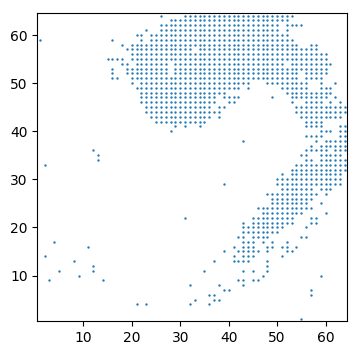

PyObject <matplotlib.collections.PathCollection object at 0x7fc2825e1400>

In [11]:
ff=figure(figsize=(4,4))
xlim(0.5,64.5)
ylim(0.5,64.5)

#scatter(canales[:,3], canales[:,2], s=0.5)
scatter(canales[:,2], canales[:,1], s=0.5)

In [12]:
yxref=[39,40]
# okey menso a barreconjunto le tienes que pasar solo las columnas con coordenadas!!!
orderchans=barreconjuntoyordena(canales[:,1:2], yxref);

alfamin = 0.015623728620476831


In [13]:
v=orderchans[:,1].==56
orderchans[v,:]

41×3 Array{Int64,2}:
 56  20  124
 56  21  138
 56  22  146
 56  23  161
 56  24  167
 56  25  182
 56  26  190
 56  27  206
 56  28  215
 56  29  234
 56  30  245
 56  31  269
 56  32  277
  ⋮         
 56  49  564
 56  50  573
 56  51  587
 56  52  592
 56  53  603
 56  54  606
 56  55  616
 56  56  621
 56  57  630
 56  58  635
 56  59  642
 56  60  645

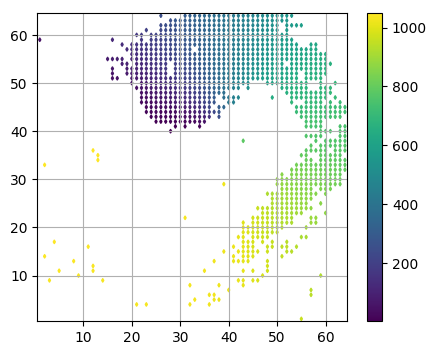

In [14]:
ff=figure(figsize=(5,4))
xlim(0.5,64.5)
ylim(0.5,64.5)
#scatter(canales[:,2], canales[:,1], s=0.5)
scatter(orderchans[:,2], orderchans[:,1], marker="d",s=3, cmap="viridis", c=orderchans[:,3])
colorbar()
grid()

In [16]:
function freediaconis(datos)
    # Freedman and Diaconis
    n=length(datos)
    m=iqr(datos)
    result=2*m/cbrt(n)
    return result
end
    
function sacaentropiafd(datos::Array)
    binsize=freediaconis(datos)
    (vmin,vmax)=extrema(datos)
    normalizador=size(datos,1)
    if(binsize != 0 )
        rango=vmin:binsize:vmax
        histodo=fit(Histogram,datos,rango)
        pdf=histodo.weights./normalizador
        result=entropy(pdf)
    else
        result=0
    end
    return result
end

sacaentropiafd (generic function with 1 method)

In [17]:
function histofreediaconis(arreglos::Array...)
    ll=length(arreglos)
    binsizes=zeros(Real,ll)
    rangos=Array{StepRangeLen}(undef, ll)     
       
    for j in 1:ll
        binsizes[j]=freediaconis(arreglos[j])
    end
    
    if any(x->x==0, binsizes)
        error(" una de tus cajas mide cero, algo esta mal")
    else
        for j in 1:ll
            (vi, vf)=extrema(arreglos[j])
            rangos[j]=vi:binsizes[j]:(vf+binsizes[j])
        end
    end
    histodo=fit(Histogram, arreglos, (rangos...,))
    return histodo
    #return rangos
end    



histofreediaconis (generic function with 1 method)

In [18]:
xx=randn(50)
yy=randn(50)
zz=randn(50);
rr3=histofreediaconis(xx,yy,zz)
rryy=histofreediaconis(yy)

Histogram{Int64,1,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}
edges:
  -1.6349489618031023:0.7235843830776554:2.7065573366628293
weights: [11, 9, 10, 14, 5, 1]
closed: left
isdensity: false

In [19]:
uno=sum(rr3.weights, dims=[1,3])
otro=rryy.weights
vec(uno)==otro
(typeof(uno), typeof(otro))

(Array{Int64,3}, Array{Int64,1})

In [20]:
fururu=[rrr.edges[2][1], rrr.edges[2][end], rrr.edges[1][1], rrr.edges[1][end]]
f9=[0,1,0,1]
imshow(rrr.weights./sum(rrr.weights), extent=fururu, origin="lower", interpolation="nearest")
colorbar()
#scatter(yy,xx, c="red", s=1)

UndefVarError: UndefVarError: rrr not defined

In [21]:
function transferentropyfd(yyfuture::Array, yypast::Array, xxpast::Array)
    hfd=histofreediaconis(yyfuture,yypast,xxpast)
    pesos=hfd.weights./sum(hfd.weights)
    #checa que conserva su "dimensionalidad" en los indices
    pypast=sum(pesos, dims=[1,3])
    pypastxpast=sum(pesos, dims=1)
    pyfutpypast=sum(pesos, dims=3)

    (KK,LL,MM)=size(pesos)
    
    sumatum=0
    
    for k=1:KK, l=1:LL, m=1:MM
        aux1=pesos[k,l,m]*pypast[1,l,1]
        aux2=pypastxpast[1,l,m]*pyfutpypast[k,l,1]
        if aux1 !=0  && aux2 !=0
            aux3=log(aux1/aux2)
            sumatum+=pesos[k,l,m]*aux3
        end
    end
    
    return sumatum
    
end

transferentropyfd (generic function with 1 method)

In [64]:
tau=round(Int, 5*freq)
xx=lfp[56,30,:]
yy=lfp[56,40,:]
xf=xx[tau:end]
xp=xx[1:end-tau+1]
yp=yy[1:end-tau+1]
transferentropyfd(xf,xp,yp)

1.2312138905946999

In [23]:
rrr=histofreediaconis(xx,yy)
rx=sum(rrr.weights, dims=2)
ry=sum(rrr.weights, dims=1)

1×250 Array{Int64,2}:
 1  0  0  0  0  1  2  0  0  0  0  0  0  …  1  0  0  2  0  0  0  0  0  0  0  2

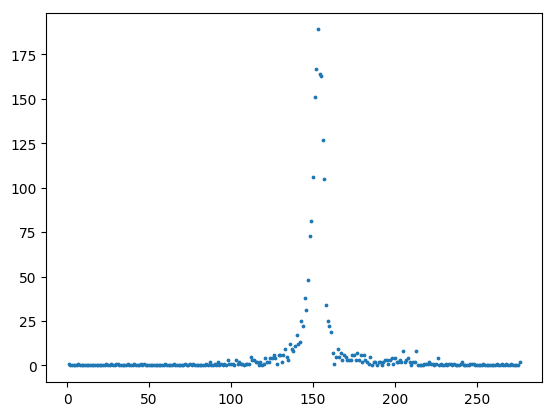

PyObject <matplotlib.collections.PathCollection object at 0x7fc262771c50>

In [24]:
scatter(1:length(rx),vec(rx), s=3)

In [55]:
function histocountmap(xxs::Array)
    dicto=countmap(xxs)
    ll=length(dicto)
    bla=zeros(ll,2)
    j=1
    for k in sort(collect(keys(dicto)))
        bla[j,1]=k
        bla[j,2]=dicto[k]
        j+=1
    end
    return bla
end

function histocountmap(xxss::Array...)
    valores=collect(zip(xxss...))
    dicto=countmap(valores)
    ll=length(dicto)
    tantas=length(xxss)
    bla=zeros(ll, tantas+1)
    j=1
    for k in sort(collect(keys(dicto)))
        for l in 1:tantas
            bla[j,l]=k[l]
        end
        bla[j,tantas+1]=dicto[k]
        j+=1
    end
    return bla
end

histocountmap (generic function with 2 methods)

In [71]:
function entrocountmap(xxs::Array)
    cuentas=histocountmap(xxs)
    pdfval=cuentas[:,2]./sum(cuentas[:,2])
    suma=0
    for j in pdfval
        suma+=j*log(j)
    end
    return (-suma)
end

function entrocountmap(xxss::Array...)
    cuentas=histocountmap(xxss...)
    #ligeramente diferente ¿sera generalizable?
    pdfval=cuentas[:,end]./sum(cuentas[:,end])
    suma=0
    for j in pdfval
        suma+=j*log(j)
    end
    return (-suma)
end


entrocountmap (generic function with 2 methods)

In [72]:
fu=histocountmap(xx,yy)
bar=entrocountmap(xx,yy)

7.258144577604487

In [82]:
fufu=fu[fu[:,3].>2,:]
typeof(fufu)

Array{Float64,2}

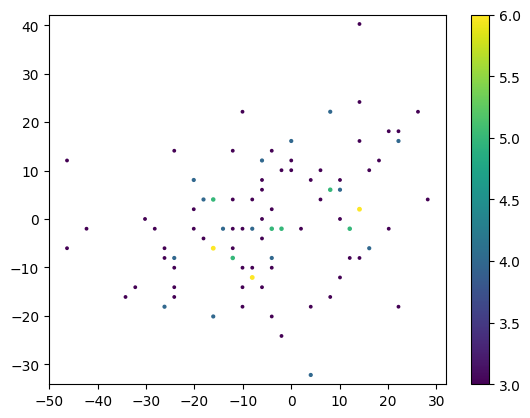

(-50.053800503667674, 31.926359097417667, -35.85500884745723, 43.91128698707785)

In [88]:
eqs=fufu[:,1]
yes=fufu[:,2]
siz=fufu[:,3]
scatter(eqs,yes, s=siz, c=siz)
colorbar()
axis("equal")

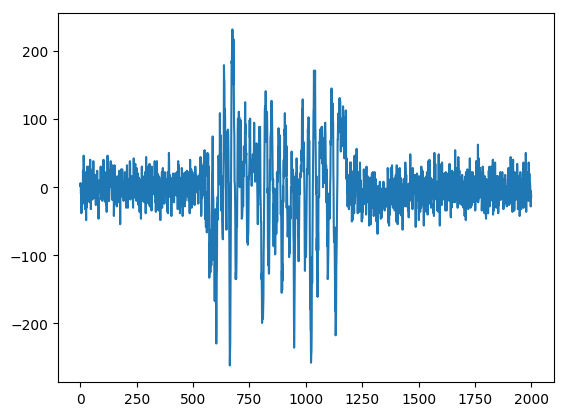

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc25c4eccf8>

In [87]:
plot(yy)

In [34]:
hetasfd=zeros(64,64)
hetascm=zeros(64,64)
for j=1:64, k=1:64
    ejemplo=lfp[j,k,:]
    hetasfd[j,k]=sacaentropiafd(ejemplo)
    hetascm[j,k]=entrocountmap(ejemplo)
end


In [35]:
dh=hetasfd-hetascm;
#map!(x->round(x ;digits=3), dh)

64×64 Array{Float64,2}:
 -0.00430033  -0.828288  -0.721642  …   0.0        0.0        0.0     
 -0.645778    -0.949897  -0.725919      0.0        0.0        0.0     
 -0.655579    -0.727874  -0.656125      0.0        0.0        0.0     
 -0.873623    -0.722449  -0.883149      0.0        0.0        0.0     
 -0.809698    -0.879922  -0.726231      0.0        0.0        0.0     
 -0.736013    -0.870958  -0.80382   …   0.0        0.0        0.0     
 -0.801438    -0.650344  -0.86598       0.0        0.0        0.0     
 -0.725109    -0.795596  -0.802805      0.0        0.0        0.0     
 -0.868443    -0.815723  -0.648623      0.0        0.0        0.0     
 -0.742314    -0.729287  -0.814583      0.0        0.0        0.0     
 -0.654961    -0.798873  -0.742495  …   0.0        0.0        0.0     
 -0.593115    -0.645372   0.0           0.0        0.0        0.0     
 -0.7153      -0.884071  -0.793444      0.0        0.0        0.0     
  ⋮                                 ⋱                

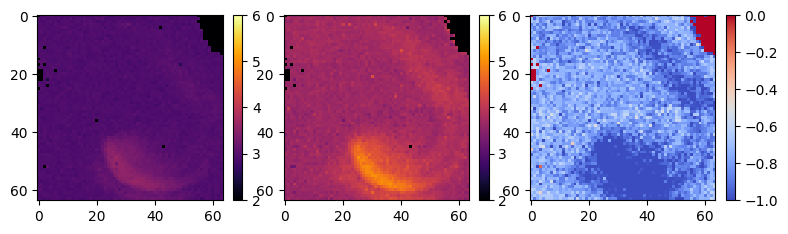

PyObject <matplotlib.colorbar.Colorbar object at 0x7fc261c6d7f0>

In [42]:
fig, (uno, dos, tres)=subplots(1,3, figsize=(9,4))
bmin=2
bmax=6
fafa=uno.imshow(hetasfd, origin="upper", cmap="inferno", vmin=bmin, vmax=bmax)
colorbar(fafa, ax=uno, fraction=0.045)
fufu=dos.imshow(hetascm, origin="upper", cmap="inferno", vmin=bmin, vmax=bmax)
colorbar(fufu, ax=dos, fraction=0.045)
fefe=tres.imshow(dh, origin="upper", cmap="coolwarm", vmin=-1, vmax=0)
colorbar(fefe, ax=tres, fraction=0.045)


In [46]:
mean(hetascm)

3.7399459847198226

In [ ]:
f=figure(figsize=(10,6))
rang=1:5*10^2
plot(rang,xx[rang], lw=0.5)
plot(rang,yy[rang], lw=0.5)

In [ ]:
vallfpdisc=zeros(64,64)
hfdiacounts=zeros(64,64)
iqrs=zeros(64,64)
for j=1:64, k=1:64
    haux=0
    try
        haux=histofreediaconis(lfp[j,k,:])
          hfdiacounts[j,k]=length(haux.edges[1])
    catch e
    end
    iqrs[j,k]=iqr(lfp[j,k,:])
  
    vallfpdisc[j,k]=length(countmap(lfp[j,k,:]))
end

In [ ]:
iqr(vec(iqrs))
mean(vec(iqrs))
mode(vec(iqrs))


In [ ]:
figure(figsize=(12,8))
fig, (uno, dos,tres)=subplots(1,3)
fafa=uno.imshow(vallfpdisc, origin="upper", vmin=110, vmax=180, cmap="inferno")
colorbar(fafa, ax=uno, fraction=0.04)
fufu=dos.imshow(hfdiacounts, origin="upper", vmin=50, vmax=400, cmap="inferno")
colorbar(fufu, ax=dos, fraction=0.04)
fefe=tres.imshow(iqrs, vmin=10,vmax=30)
colorbar(fefe, ax=tres, fraction=0.04)


In [ ]:
imshow(hfdiacounts)

In [ ]:
vv=vec(vallfpdisc)
ll=length(countmap(vv))
jhh=fit(Histogram, vv, 18:160)
ta=jhh.weights
tu=jhh.edges[1]
size(collect(tu[1:end-1])), size(ta)
plot(tu[1:end-1], ta)

In [ ]:
typeof(vv)

In [ ]:
function sacaentropia(datosX::Array, datosY::Array)
    # ambos arrays deben ser igual de largos ???
    binsizeX=freediaconis(datosX)
    binsizeY=freediaconis(datosY)
    if (binsizeX==0 || binsizeY==0)
        error(" ¡Esto que, no tiene variacion en los datos!")
    else
        (viX,vfX)=extrema(datosX)
        (viY,vfY)=extrema(datosY)
        rangoX=viX:binsizeX:vfX
        rangoY=viY:binsizeY:vfY
        
        histodo=fit(Histogram, (datosX, datosY), (rangoX, rangoY))
        
        pdf=histodo.weights
        pdf=pdf./sum(pdf)
        result=entropy(pdf)
        return result
        #return (result, histodo)
    end

end

In [ ]:
function infomutua(datosX::Array, datosY::Array)
    hetaX=sacaentropia(datosX)
    hetaY=sacaentropia(datosY)
    hetaXY=sacaentropia(datosX,datosY)
    result=hetaX+hetaY-hetaXY
    return result
end

In [ ]:
nchan=size(orderchans, 1)
hetas=zeros(nchan)
for j=1:nchan
    reng,col=orderchans[j,1],orderchans[j,2]
    ejemplo=lfp[reng,col,:]
    hetas[j]=sacaentropia(vec(ejemplo))
end

In [ ]:
ff=figure(figsize=(7,6.7))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(orderchans[:,2], orderchans[:,1], s=hetas, c=hetas, cmap="Reds")
colorbar()
grid()

In [ ]:
hetacut=quantile(hetas, 0.90)
tuabueta=findall(x->x>hetacut,hetas);
auxchans=hcat(orderchans[tuabueta,:], hetas[tuabueta])
naux=size(auxchans,1)

In [ ]:
ff=figure(figsize=(7,6.7))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(auxchans[:,2], auxchans[:,1], s=auxchans[:,4], 
    c=auxchans[:,4],marker="s", cmap="Reds")
colorbar()
grid()

In [ ]:
imutres=zeros(nchan)
refe=[50,28]
fijo=lfp[refe[1], refe[2],:]
for j=1:nchan
    reng,col=orderchans[j,1],orderchans[j,2]
    ejemplo=lfp[reng,col,:]
    imutres[j]=infomutua(fijo, ejemplo)
end

In [ ]:
ff=figure(figsize=(7,6.7))
xlim(0.5,64.5)
ylim(0.5,64.5)
scatter(orderchans[:,2], orderchans[:,1], s=imutres.*5, c=imutres, cmap="cividis", marker="s")
colorbar()
#grid()

In [ ]:
figure(figsize=(10,3))
plot(hetas, lw=0.3)

In [ ]:
mutinfo=zeros(naux,naux);
crossentro=zeros(naux,naux)

for j=1:naux
    for k=j:naux
        
        reng1,col1=(auxchans[j,1], auxchans[j,2])
        reng2,col2=(auxchans[k,1], auxchans[k,2])
        
        reng1=round(Int32, reng1)
        reng2=round(Int32, reng2)
        
        col1=round(Int32, col1)
        col2=round(Int32, col2)
        
        
        
        dat1=lfp[reng1, col1,:]
        dat2=lfp[reng2, col2,:]
        
        mutinfo[j,k]=infomutua(dat1,dat2)
        mutinfo[k,j]=mutinfo[j,k]
    
    end
end

In [ ]:
for j=1:naux
    mutinfo[j,j]=0
end

In [ ]:
figure(figsize=(6,5))

imshow(mutinfo, cmap="inferno", interpolation="nearest", vmin=0.6, vmax=1.6)

#onde=[55, 125, 200, 250]
onde=[20, 45, 70, 90]
que=["CA3c","CA3b", "CA3a", "CA2?" ]
tick_params(bottom=false, top=true)
xticks(onde, que)
yticks(onde, que)
tick_params(bottom=false, top=true, labeltop=true, labelbottom=false)

colorbar(fraction=0.046, pad=0.04)

In [ ]:
?crossentropy